# import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb
import time

%matplotlib inline

# load data

## naive features
1. 生成df_all
2. 从df_all中删除以下属性price_doc

In [11]:
# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
df_all.set_index('id', inplace=True)

# 更新build_year 
# StateNew-NaiveXgbMixture-SingleDefault2017060401
build_year_new = pd.read_csv('../output/feat/BuildYearNew-NaiveXgbMixture-SingleDefault2017060200.csv', index_col='id')
df_all['gaoyl_build_year_state'] = 0
df_all.loc[df_all.build_year.isnull(), 'gaoyl_build_year_state'] = -1
df_all.loc[df_all.build_year.notnull() & df_all.build_year <= 1800, 'gaoyl_build_year_state'] = df_all.loc[df_all.build_year.notnull() & df_all.build_year <= 1800, 'build_year']
df_all.drop(['build_year'], axis=1, inplace=True)
df_all['build_year'] = build_year_new.build_year
df_all['gaoyl_time_offset'] = df_all.timestamp.dt.year - df_all.build_year

# Add month-year
# 新特征 哪年哪月（交易量）
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
# 新特征 一年中的第几周（交易量）
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# 新特征 几月份（交易 ）和 星期几（交易）
df_all['sell_year'] = df_all.timestamp.dt.year
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
# 新特征，楼层位置，厨房面积占比
# df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

sub_area_map = df_all.sub_area.value_counts().to_dict()
df_all['gaoyl_subarea_cnt'] = df_all.sub_area.map(sub_area_map)

to_drop = ['gaoyl_rest_sq', 'price_doc']
to_drop = ['gaoyl_rest_sq'] # StateNew-NaiveXgbMixture-SingleDefault2017060402-WithPrice
df_all.drop(filter(lambda x: x in df_all.columns, to_drop), axis=1, inplace=True)

## show max floor

Missing 0.314134751075 percent in train set 30471 samples.
Missing 0.0 percent in test set 7662 samples.
-----train-----


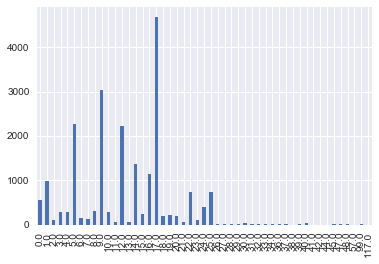

-----test-----


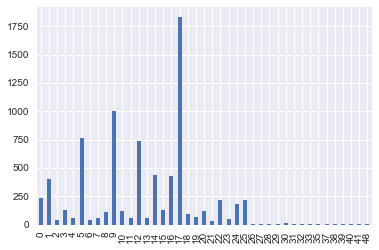

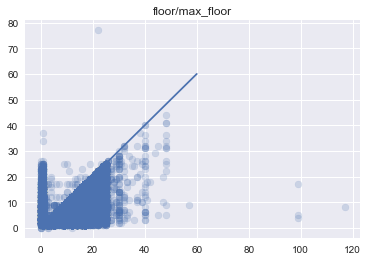

wrong 2136
floor 37966
26425


In [16]:
target_column = 'max_floor'
print 'Missing {} percent in train set {} samples.'.format(df_train[target_column].isnull().mean(), df_train.shape[0])
print 'Missing {} percent in test set {} samples.'.format(df_test[target_column].isnull().mean(), df_test.shape[0])

print '-' * 5 + 'train' + '-' * 5
df_train[target_column].value_counts().sort_index().plot(kind='bar')
plt.show()
print '-' * 5 + 'test' + '-' * 5
df_test[target_column].value_counts().sort_index().plot(kind='bar')
plt.show()

floor = df_all[df_all[target_column].notnull()].floor.values
max_floor = df_all[df_all[target_column].notnull()].max_floor.values

plt.scatter(max_floor, floor, alpha=.2)
plt.plot([0, 20, 40, 60], [0, 20, 40, 60])
plt.title('floor/max_floor')
plt.show()

print 'wrong', (df_all.floor > df_all.max_floor).sum()
print 'floor', df_all.floor.notnull().sum()
is_valid = df_all[target_column].notnull() & (df_all[target_column] >= df_all.floor)
print is_valid.sum()

## split train & test for target_column
1. 根据是否有合理的target_column拆分数据集，生成train\test\train_test三个dataframe
2. 生成ndarray X_train_all, y_all, X_test
3. 生成ndarray X_train, y_train, X_val, y_val

In [13]:
target_column = 'max_floor'
df_all.reset_index(inplace=True)

df_all[target_column] = df_all[target_column]
target_column_valid = df_all[target_column].notnull() & (df_all[target_column] >= df_all.floor)
train = df_all.loc[target_column_valid].copy()
test = df_all.loc[target_column_valid.apply(lambda x: not x)].copy()
print 'train {}, test {}'.format(train.shape[0], test.shape[0])

train_id = train['id']
test_id = test['id']

y_all = train[target_column].astype(np.int64)

train.drop(['id', target_column], axis=1, inplace=True)
test.drop(['id', target_column], axis=1, inplace=True)
train_test = pd.concat([train, test])

num_train = train.shape[0]

# Deal with categorical values
# 对object类型的数据用正整数编码,这样处理后空值也有编码
df_numeric = train_test.select_dtypes(exclude=['object'])
df_obj = train_test.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

to_drop = ['timestamp']
df_values.drop(filter(lambda x: x in df_values.columns, to_drop), axis=1, inplace=True)


# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
y_train = y_all[:-num_val]
y_val = y_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', y_val.shape)
print('X_test shape is', X_test.shape)

train 26425, test 11708
(38133L, 311L)
('X_train_all shape is', (26425L, 311L))
('X_train shape is', (21140L, 311L))
('y_train shape is', (21140L,))
('X_val shape is', (5285L, 311L))
('y_val shape is', (5285L,))
('X_test shape is', (11708L, 311L))


# xgboost single model

* withPrice:  [156]	val-mlogloss:0.640786

## best round + 20

In [14]:
dtrain_all = xgb.DMatrix(X_train_all, y_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`

partial_model = xgb.train(xgb_params, dtrain, evals=[(dval, 'val')],
                          num_boost_round=1000,
                          early_stopping_rounds=25,
                          verbose_eval=25)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:13.6127
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.88841
[50]	val-rmse:3.21057
[75]	val-rmse:2.98196
[100]	val-rmse:2.92452
[125]	val-rmse:2.88944
[150]	val-rmse:2.86948
[175]	val-rmse:2.86614
[200]	val-rmse:2.85183
[225]	val-rmse:2.84346
[250]	val-rmse:2.83862
[275]	val-rmse:2.8355
[300]	val-rmse:2.82898
[325]	val-rmse:2.8197
[350]	val-rmse:2.81506
[375]	val-rmse:2.81196
[400]	val-rmse:2.80583
[425]	val-rmse:2.80321
[450]	val-rmse:2.8005
[475]	val-rmse:2.79899
[500]	val-rmse:2.79353
[525]	val-rmse:2.79032
[550]	val-rmse:2.7912
Stopping. Best iteration:
[531]	val-rmse:2.78913



## best round + 20 feature importance
build_year 958
price_doc 879

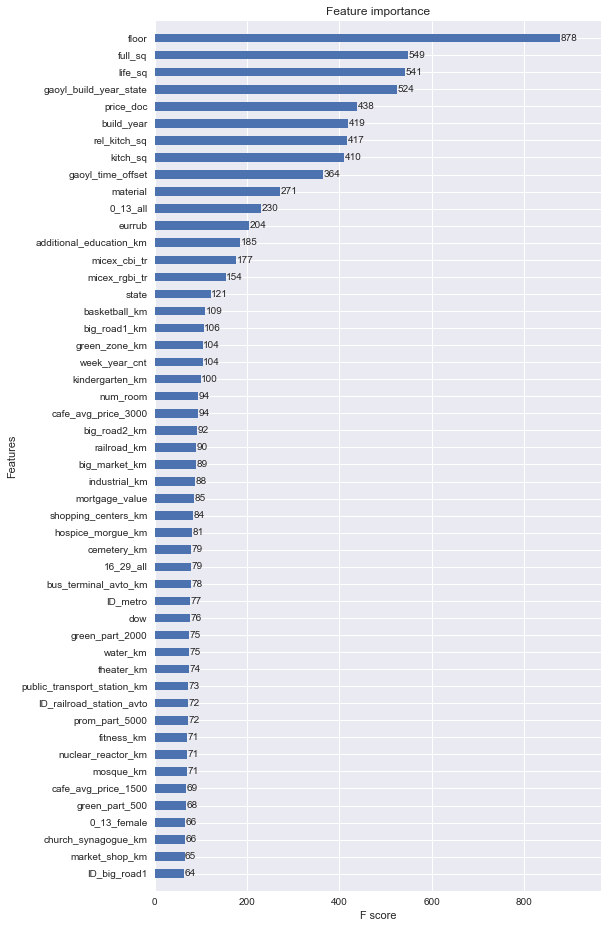

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)

## best round

In [17]:
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

## best round feature importance

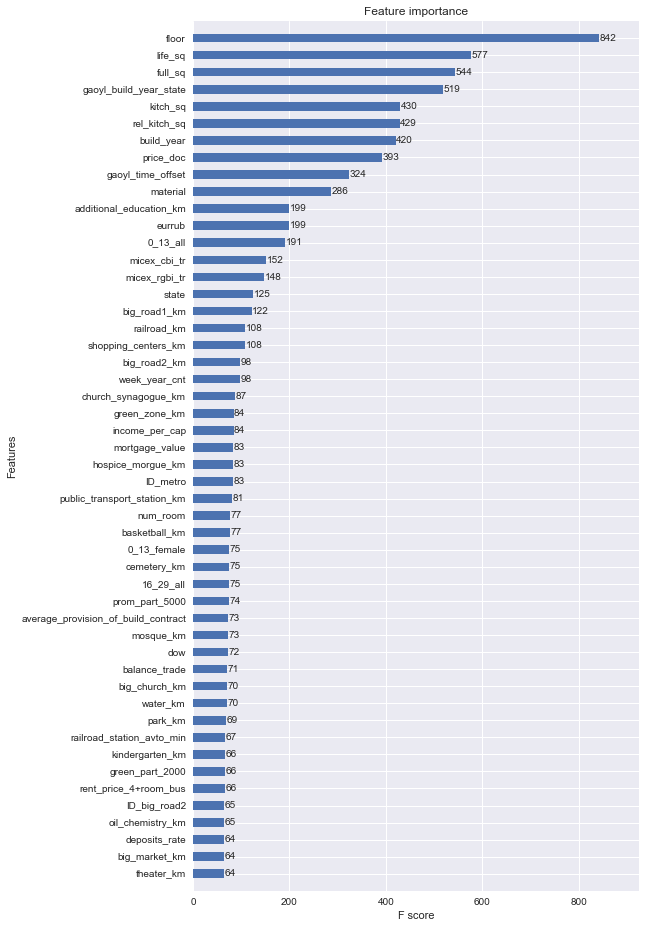

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

## predicted state

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


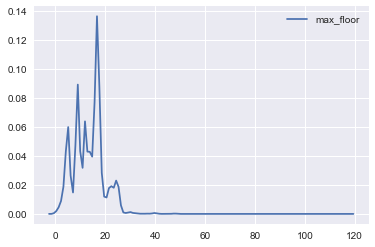

D:\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


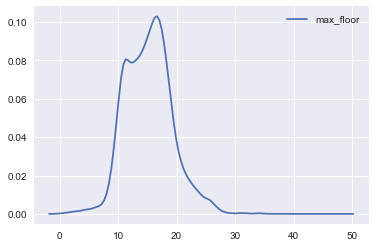

In [20]:
target_column = 'max_floor'
y_pred = model.predict(dtest)

df_pred = pd.DataFrame({'id': test_id, target_column: y_pred})
df_real = pd.DataFrame({'id': train_id, target_column: y_all.values})
df_build_year_new = pd.concat([df_real, df_pred])
df_build_year_new.to_csv('../output/feat/MaxFloor-NaiveXgbMixture-SingleDefault2017060400-WithPrice.csv', index=False)

sns.kdeplot(y_all)
plt.show()
sns.kdeplot(df_pred[target_column])
plt.show()

# xgboost stacking @TODO

In [10]:
import sys
sys.path.append('..')
from my_py_models.stacking import Stacking
from my_py_models.my_xgb_classifier import MyXgbClassifier